# <u><center> Project 5: Part 3 Core
* Authored By: Eric N. Valdez
* Date: 03-17-2024

# <u>Imports:

In [44]:
#Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Deep learning tools
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError

#Evaluation tools
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from tensorflow import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, \
classification_report, ConfusionMatrixDisplay, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn import set_config, config_context
set_config(transform_output='pandas')
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

# Set random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# <u>Custome Functions:

In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [3]:
def eval_classification(true, pred, name, labels=None):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred, target_names=labels))
    ConfusionMatrixDisplay.from_predictions(true, pred, display_labels=labels, )

    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

# <u>Task:
* Build a small neural Network (with only 1 hidden layer)
   * Ensure the Final layer is appropriate for your task (number of units and activation function)
   * Fit it for 50 epochs
       *  Use Early Stopping callbacks
           * Start with patience = 5 monitoring val_accuracy.
       * Use a validation_split of 2
       * Save the history and visualize it.  
    * Evaluate the model using sklearn evaluation metrics:
        * Confusion Matrix
        * Classification Report
        * You are Welcome to use the custom  evaluation functions  

* Tune at least 3 parameters with Keras tuner:
    * Include a dropout layer and adjust the dropout rate
    * Number of units
    * Optimizer
    * Learning rates 
* Evaluate your best model on unseen test data

# <u>Load Data:

In [4]:
# Loading clean data that I created from Part1
df = pd.read_csv('Data/clean_MetSyndr.csv', index_col = 'seqn')
df.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200.00000,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.00000,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.00000,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
62172,43,Female,Single,2000.00000,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
62177,51,Male,Married,4005.25394,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2401 entries, 62161 to 71915
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   Sex                2401 non-null   object 
 2   Marital            2401 non-null   object 
 3   Income             2401 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2401 non-null   float64
 6   BMI                2401 non-null   float64
 7   Albuminuria        2401 non-null   int64  
 8   UrAlbCr            2401 non-null   float64
 9   UricAcid           2401 non-null   float64
 10  BloodGlucose       2401 non-null   int64  
 11  HDL                2401 non-null   int64  
 12  Triglycerides      2401 non-null   int64  
 13  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(5), object(4)
memory usage: 281.4+ KB


In [7]:
# Checking for any duplicates
df.duplicated().sum()

0

In [8]:
# Checking to make sure my data is clean
df.isna().sum()

Age                  0
Sex                  0
Marital              0
Income               0
Race                 0
WaistCirc            0
BMI                  0
Albuminuria          0
UrAlbCr              0
UricAcid             0
BloodGlucose         0
HDL                  0
Triglycerides        0
MetabolicSyndrome    0
dtype: int64

In [9]:
df['MetabolicSyndrome']=df['MetabolicSyndrome'].replace({'No MetSyn': 0, 'MetSyn': 1})
df['MetabolicSyndrome'].value_counts()

0    1579
1     822
Name: MetabolicSyndrome, dtype: int64

# <u>Preprocess Data for Machine Learning

In [10]:
# Train Test Split
X= df.drop(columns='MetabolicSyndrome')
y=df['MetabolicSyndrome'].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [11]:
# Looking at X_train DF
X_train.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
seqn,,,,,,,,,,,,,
63211,46,Female,Married,8200.0,White,124.0,40.8,0,18.47,3.3,140,53,198
70548,34,Male,Separated,3500.0,MexAmerican,86.2,24.5,0,16.14,6.1,114,83,60
64722,33,Female,Married,3500.0,MexAmerican,75.0,25.0,0,11.54,3.4,97,44,60
69237,49,Female,Married,9000.0,Hispanic,95.7,33.3,0,3.81,2.7,89,51,139
65286,30,Male,Married,9000.0,Asian,75.7,21.9,0,7.76,7.1,81,58,394


In [12]:
ordcol = X_train[['Albuminuria']].columns
catcol = X_train.select_dtypes('object').columns
numcol = X_train.select_dtypes('number').drop(columns=ordcol).columns

In [13]:
#Instantiate the transformers
from sklearn.impute import KNNImputer
scaler=StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
knnimpute= KNNImputer(n_neighbors=3)
oheimpute = SimpleImputer(strategy='constant', fill_value='none')

In [14]:
#Create pipelines
num_pipe= make_pipeline(knnimpute, scaler)
cat_pipe= make_pipeline(oheimpute, ohe)

In [15]:
num_tuple= ("Numeric", num_pipe, numcol)
cat_tuple=("Catagorical", cat_pipe, catcol)
ord_tuple= ("Ordinal", scaler, ordcol)
preprocessor = ColumnTransformer([num_tuple, cat_tuple, ord_tuple], remainder='passthrough')

In [16]:
preprocessor.fit(X_train)
X_train_tf=preprocessor.transform(X_train)
X_test_tf=preprocessor.transform(X_test)

## `Model 1`

In [17]:
# Save the number of features we have as our input shape
input_shape = X_train_tf.shape[1]
input_shape

24

In [18]:
# Step 1 Build Network Structure

# Sequential model
model = keras.Sequential()

model.add(Dense(20, input_dim=input_shape, activation ='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

#Step 2: compile
model.compile(loss = 'bce', optimizer = 'adam'
              ,metrics=['accuracy', metrics.Precision(), metrics.Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                500       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Use Early Stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=3)

In [20]:
# Fitting the model
history = model.fit(X_train_tf, y_train,
                        validation_split=.2,
                        epochs=50, callbacks = [early_stop])

Epoch 1/50
45/45 [==============================] - 1s 14ms/step - loss: 0.6023 - accuracy: 0.6924 - precision: 0.5453 - recall: 0.5103 - val_loss: 0.5525 - val_accuracy: 0.7444 - val_precision: 0.7188 - val_recall: 0.5149
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 0.5085 - accuracy: 0.7653 - precision: 0.6931 - recall: 0.5413 - val_loss: 0.4801 - val_accuracy: 0.7833 - val_precision: 0.7692 - val_recall: 0.5970
Epoch 3/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4471 - accuracy: 0.7889 - precision: 0.7163 - recall: 0.6157 - val_loss: 0.4267 - val_accuracy: 0.8083 - val_precision: 0.7928 - val_recall: 0.6567
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4046 - accuracy: 0.8104 - precision: 0.7403 - recall: 0.6715 - val_loss: 0.3878 - val_accuracy: 0.8194 - val_precision: 0.7805 - val_recall: 0.7164
Epoch 5/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3760 - accuracy: 0.8229 - precision: 

In [21]:
# Convert the history to a dataframe for readability
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.602250,0.692361,0.545254,0.510331,0.552507,0.744444,0.718750,0.514925
1,0.508457,0.765278,0.693122,0.541322,0.480078,0.783333,0.769231,0.597015
2,0.447140,0.788889,0.716346,0.615702,0.426667,0.808333,0.792793,0.656716
3,0.404605,0.810417,0.740319,0.671488,0.387800,0.819444,0.780488,0.716418
4,0.376002,0.822917,0.753880,0.702479,0.362823,0.830556,0.782946,0.753731
5,0.356059,0.831944,0.757447,0.735537,0.351158,0.844444,0.819672,0.746269
6,0.342502,0.848611,0.806452,0.723140,0.342382,0.844444,0.800000,0.776119
7,0.332869,0.850000,0.793860,0.747934,0.338749,0.838889,0.822034,0.723881
8,0.325393,0.862500,0.820628,0.756198,0.333357,0.847222,0.806202,0.776119
9,0.320373,0.853472,0.793548,0.762397,0.334639,0.841667,0.823529,0.731343


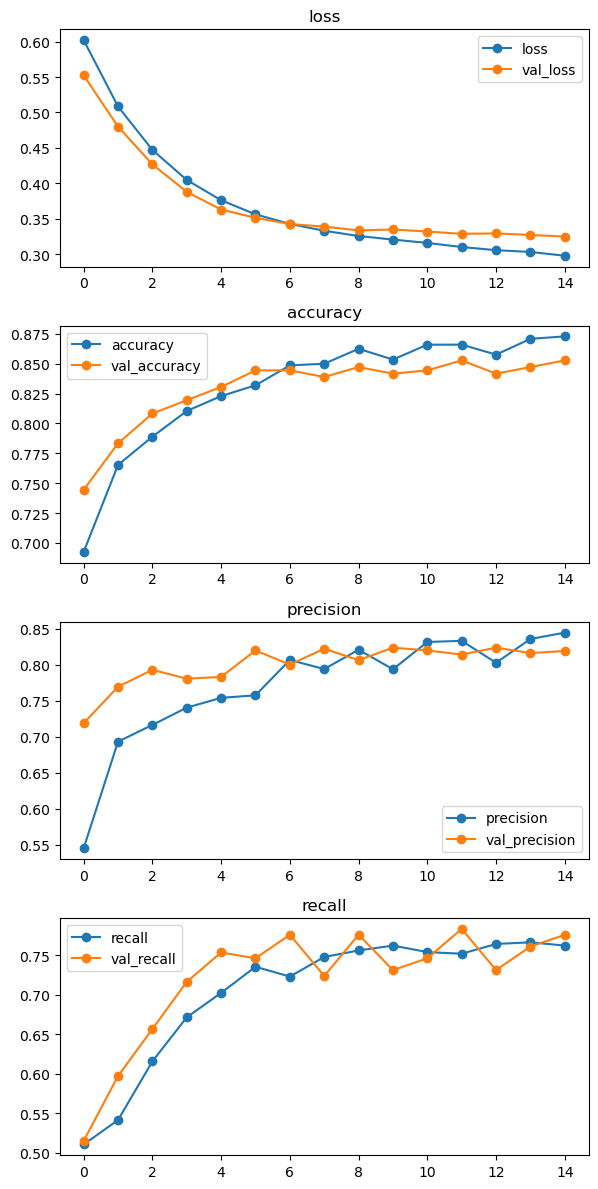

In [23]:
# Apply the custom function plot_history() to see how your model is doing
plot_history(history);

In [24]:
# make predictions
y_pred_test= model.predict(X_test_tf)
y_pred_test[:5]

19/19 [==============================] - 0s 927us/step


array([[0.32184473],
       [0.83181506],
       [0.2540363 ],
       [0.29308462],
       [0.9983453 ]], dtype=float32)

In [25]:
#evaluate with sklearn metrics
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]

array([[0.],
       [1.],
       [0.],
       [0.],
       [1.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       397
           1       0.77      0.72      0.74       204

    accuracy                           0.83       601
   macro avg       0.81      0.80      0.81       601
weighted avg       0.83      0.83      0.83       601



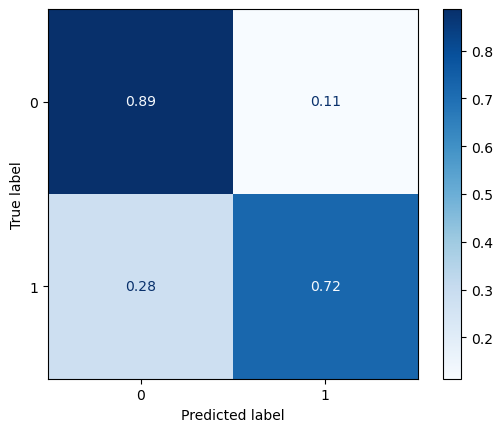

In [26]:
print(classification_report(y_test, y_pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues', normalize="true");

## `Model 2: Tune Parameters with Keras Tuner`

In [29]:
# Additional Imports
from keras_tuner import HyperParameters as hp
import keras_tuner as kt
import os
folder='KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [30]:
# Step 1 Build Network Structure

# Sequential model
def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    opitimizers = hp.Choice('optimizer', ['rmsprop','nadam','adam'])
    dropout= hp.Boolean('dropout')   
   
    model2 = Sequential()
    model2.add(Dense(units=units, activation ='relu'))
  
    if dropout:
           model2.add(Dropout(.2))
                  
    model2.add(Dense(1, activation = 'sigmoid'))

#Step 2: compile
    model2.compile(loss = 'bce', optimizer = opitimizers,
                      metrics=['accuracy'])
    
    return model2

In [31]:
# define tuner object
tuner= kt.Hyperband(build_model, objective='val_accuracy',
                    max_epochs= 8,
                    directory=folder,
                    overwrite=True,
                    seed=42,
                    project_name='MetSNeural Network')

In [32]:
epochs=50
tuner.search(X_train_tf, y_train, epochs=epochs, 
             validation_data= (X_test_tf, y_test), callbacks=[early_stop])

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.8319467306137085

Best val_accuracy So Far: 0.8386023044586182
Total elapsed time: 00h 00m 25s
INFO:tensorflow:Oracle triggered exit


In [33]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 288,
 'optimizer': 'rmsprop',
 'dropout': False,
 'tuner/epochs': 8,
 'tuner/initial_epoch': 3,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0002'}

In [34]:
# Use Early Stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=3)

In [35]:
#build model with best hp
model2 = build_model(best_hps)
#fit model
history2 = model2.fit(X_train_tf,y_train, validation_split=.2,
                        epochs=50, callbacks=[early_stop])

Epoch 1/50
45/45 [==============================] - 1s 11ms/step - loss: 0.4490 - accuracy: 0.8014 - val_loss: 0.3803 - val_accuracy: 0.8194
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3607 - accuracy: 0.8444 - val_loss: 0.3506 - val_accuracy: 0.8333
Epoch 3/50
45/45 [==============================] - 0s 2ms/step - loss: 0.3371 - accuracy: 0.8521 - val_loss: 0.3404 - val_accuracy: 0.8528
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3239 - accuracy: 0.8597 - val_loss: 0.3365 - val_accuracy: 0.8306
Epoch 5/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3134 - accuracy: 0.8674 - val_loss: 0.3277 - val_accuracy: 0.8556
Epoch 6/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3045 - accuracy: 0.8674 - val_loss: 0.3355 - val_accuracy: 0.8278
Epoch 7/50
45/45 [==============================] - 0s 3ms/step - loss: 0.2974 - accuracy: 0.8687 - val_loss: 0.3239 - val_accuracy: 0.8444
Epoch 8/50
45/45 [=

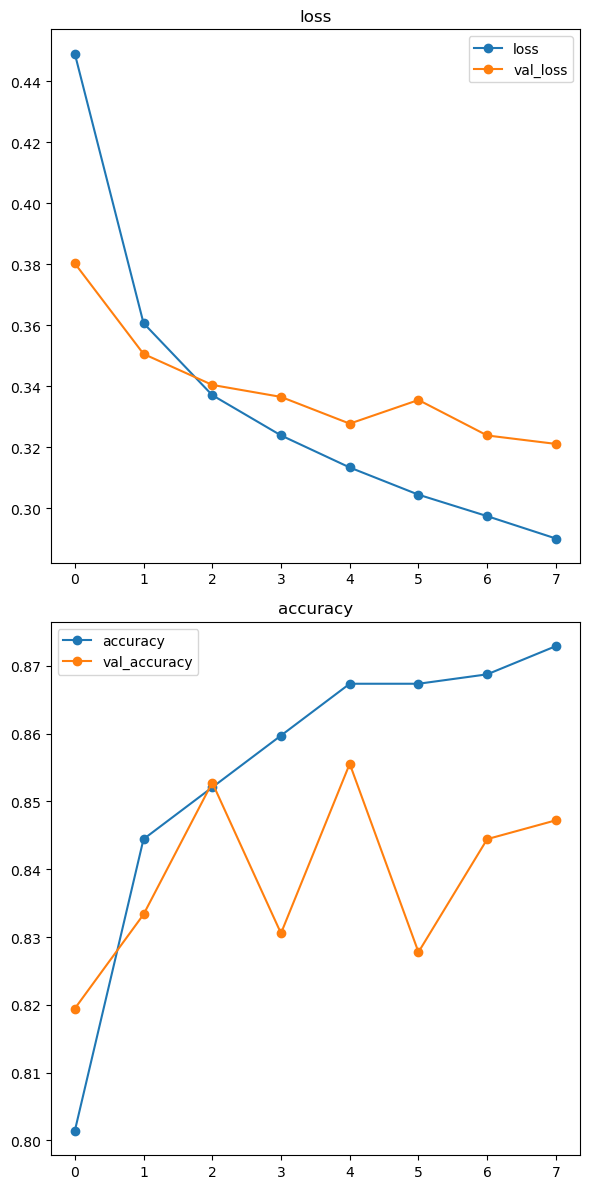

In [36]:
# Apply the custom function plot_history() to see how your model is doing
plot_history(history2);

In [37]:
result=model2.evaluate(X_test_tf, y_test, return_dict=True)
result

19/19 [==============================] - 0s 1ms/step - loss: 0.3520 - accuracy: 0.8303


{'loss': 0.3519628345966339, 'accuracy': 0.8302828669548035}

In [38]:
# make predictions
y_pred_test2= model2.predict(X_test_tf)
y_pred_test2[:5]

19/19 [==============================] - 0s 1ms/step


array([[0.20618798],
       [0.7715026 ],
       [0.37736663],
       [0.38812235],
       [0.9946558 ]], dtype=float32)

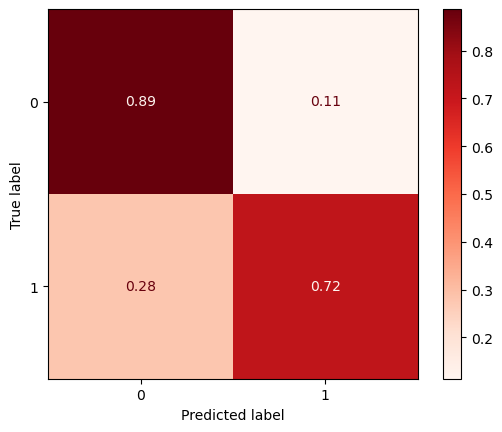

In [40]:

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Reds', normalize="true");

In [47]:
# print(classification_report(y_test, y_pred_test2))

<!-- ## `Evaluate Model`
- The model 1 has an accuracy score of 0.82
- The model 2 using keras tuner has an accuracy score of 0.83
- Of the models the default model performs the best
    - Both models show a point where the models become overfit
        - Perhaps using a lower patience during early stopping would prevent this. -->

## `Model 3`

In [48]:
# Build binary classification model within function
def build_model3():
    # Instantiate Model
    model3 = Sequential()

    # First hidden layer
    model3.add(Dense(24, input_dim =in_shape,
                          activation = 'relu'))
    model3.add(Dropout(.12))

    model3.add(Dense(1, activation = 'sigmoid'))

    # Compile Model
    model3.compile(loss = 'bce', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model3

In [49]:
# Call our build function to build model
n_model3 = build_model3()

# Get model summary
n_model3.summary()

NameError: name 'in_shape' is not defined

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
history2 = n_model3.fit(X_train_nn, y_train,
                        validation_data = (X_test_nn, y_test),
                         validation_split = .2, epochs = 50, verbose=0,
                       callbacks = [early_stop])

In [ ]:
# plot learning history
plot_history(history3);

In [ ]:
# Get predictions
train_pred_proba = n_model3.predict(X_train_nn)
test_pred_proba = n_model3.predict(X_test_nn)


# round predictions to integers instead of floats using np.rint()
train_preds = np.rint(train_pred_proba)
test_preds = np.rint(test_pred_proba)

# the following code should show whole number predictions, 1.0 or 0.0
print(test_preds[:5])
print(train_preds[:5])

In [ ]:
# Define labels for the confusion matrix
labels = ['No Metabolic Syndrome', 'Metabolic Syndrome']

train_scores = eval_classification(y_train, train_preds, labels=labels, name='Model 3 Train')
test_scores = eval_classification(y_test, test_preds, labels=labels, name='Model 3 Test')

scores = pd.concat([scores, pd.concat([train_scores, test_scores])])
scores

In [ ]:
# # Make predictions and evaluate your model
# train_preds = model3.predict(X_train)
# test_preds = model3.predict(X_test)

# train_scores = eval_regression(y_train, train_preds, name='model3_reg_train')
# test_scores = eval_regression(y_test, test_preds, name='model3_reg_test')

# reg_scores = pd.concat([train_scores, test_scores])
# reg_scores

<!-- # Including a dropout layer did not improve the model. Let's find out if we are using the best optimizer. -->